In [2]:
import os
import jax, jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import yaml
import pandas as pd

from pcg_stein.registry import PRECON_REGISTRY

import seaborn as sns


import matplotlib as mpl
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

os.getcwd()

'/home/matth/dev/python/jax/pcg_stein/experiments/fig1_experiment'

#### Load Data and Define Metrics

In [3]:
path = os.path.join('results', 'fig1_test.csv')
results = pd.read_csv(path)

In [ ]:
import yaml

with open('experiment.yaml') as f:
    cfg = yaml.safe_load(f)

lengthscale_labels = cfg['ln_lengthscales']
nugget_labels = cfg['ln_nuggets']
block_labels = cfg["block_sizes"]

results["gain"] = np.log(results["m_cg"] + 1) - np.log(results["m_pcg"]  + 1) # defining gain
results["diff"] = results["m_cg"] - results["m_pcg"] # defining the raw difference


#### Make Plot Function

In [ ]:
def make_plot(result_df, metric="gain", ncols=3, fig_mul=3, cbar_label="Gain"):

    df = result_df.copy()
    # pick the non-NA parameter for every row
    df["param"] = np.where(df["nugget"].notna(), df["nugget"], df["block_size"])

    df_mean = (
        df.groupby(["precon", "lengthscale", "param"], as_index=False)[metric]
        .mean()
    )

    df_se = (
        df.groupby(["precon", "lengthscale", "param"], as_index=False)[metric]
        .sem()
    )

    precons =  sorted(df_mean["precon"].unique()) # 6 of them
    n_rows, n_cols = 2, 3  # grid shape

    # 1) Compute values and global vmin/vmax for colorbar
    all_vals = []

    for pre in precons:
        heat = (
            df_mean[df_mean["precon"] == pre]
            .pivot(index="param", columns="lengthscale", values=metric)
            .values
        )
        all_vals.append(heat)

    all_vals = np.concatenate([h.flatten() for h in all_vals])
    vmin, vmax = all_vals.min(), all_vals.max()
    cmax = max(abs(vmin), abs(vmax)) 

    # 2) Make subplots
    n = len(precons)
    cols = ncols
    rows = int(np.ceil(n/cols))
    fig, axes = plt.subplots(rows, cols, figsize=(fig_mul*cols, fig_mul*rows), 
                            constrained_layout=False)

    for i, pre in enumerate(precons):
        ax = axes.flat[i]
        heat = (
            df_mean[df_mean["precon"] == pre]
            .pivot(index="param", columns="lengthscale", values=metric)
            .sort_index()
        )

        heat_se = (
            df_se[df_se["precon"] == pre]
            .pivot(index="param", columns="lengthscale", values=metric)
            .sort_index()
        )

        se_data = heat_se.values # for plotting standard error strings
        mean_data = heat.values

        display_name = PRECON_REGISTRY[pre]().display_name

        sns.heatmap( # draw heatmap
            heat,
            ax=ax,
            cmap="coolwarm",
            vmin=-cmax,
            vmax=+cmax,
            cbar=False,  # turn off individual colorbars
            xticklabels=lengthscale_labels,
            yticklabels=block_labels if pre == "BlockJacobi" else nugget_labels,
        )


        thresh = cmax * 2 / 3 # threshold for text color change

        for i in range(se_data.shape[0]): # draw standard errors
            for j in range(se_data.shape[1]):
                mean_val = mean_data[i, j] # used to decide color
                se_val = se_data[i, j]
                color = "black" if mean_val < thresh and mean_val > -thresh else "white"
                ax.text(j + 0.5, i + 0.5, f"{se_val:.2f}", ha="center", va="center", color=color)

        ax.set_title(display_name, fontsize=12)
        ax.set_xlabel(r"$\ln \ell $", fontsize=10)
        ax.set_ylabel(r"$b$" if pre == "BlockJacobi" else r"$\ln \eta$", fontsize=10)
        ax.invert_yaxis()

    # hide any empty axes
    for ax in axes.flat[len(precons):]:
        ax.axis("off")

    # 3) Add one global colorbar
    # place it on the right [left, bottom, width, height]
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    norm = plt.Normalize(vmin=-cmax, vmax=+cmax)
    sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
    sm.set_array([])  # only needed for the colorbar

    fig.colorbar(sm, cax=cbar_ax, label=cbar_label)

    # adjust so there's space for the colorbar
    plt.tight_layout()

    plt.subplots_adjust(right=0.9, top=0.95, bottom=0.1)

    return fig, axes


### Create Figures and Save

/tmp/ipykernel_491306/3133049458.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


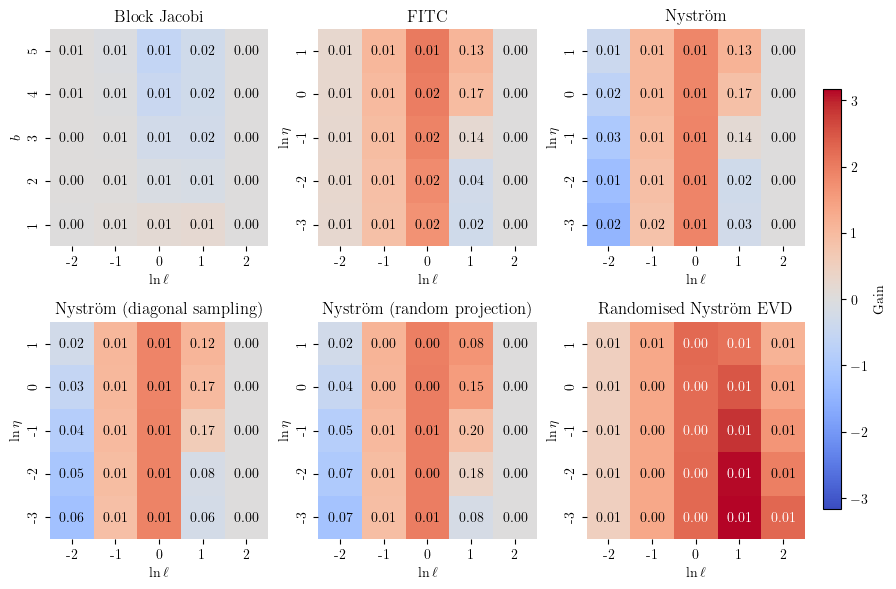

In [ ]:
fig1, _ = make_plot(results, metric="gain", cbar_label="Gain")

fig1.savefig(
    "fig1.pdf",  
    format="pdf",     
    bbox_inches="tight",  
    pad_inches=0          
)

/tmp/ipykernel_491306/3133049458.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


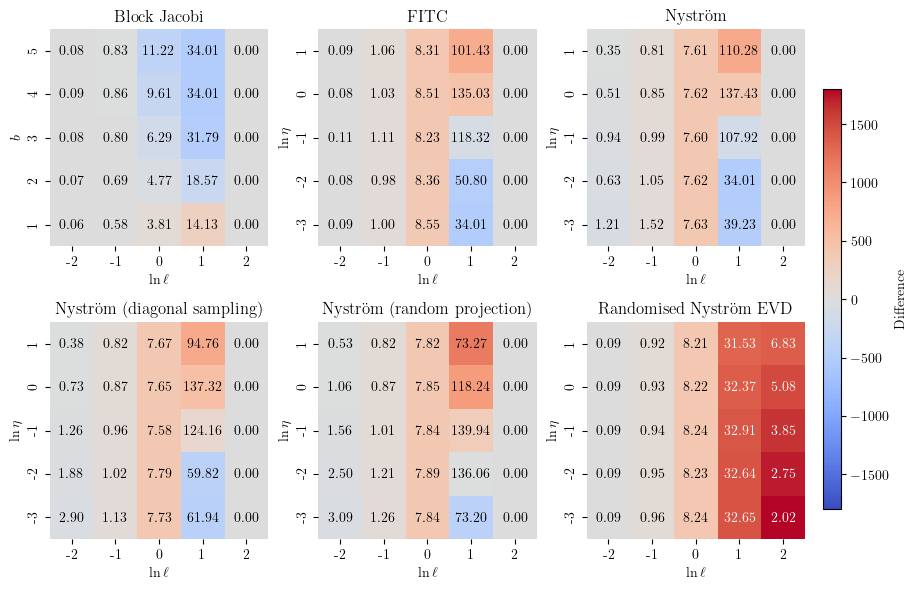

In [ ]:
fig1_diff, _ = make_plot(results, metric="diff", cbar_label="Difference")

fig1_diff.savefig(
    "fig1_diff.pdf",    
    format="pdf",         
    bbox_inches="tight", 
    pad_inches=0          
)